In [1]:
import math
import os
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils import data

from torchvision import datasets
from torchvision import transforms
from torchvision import utils

random.seed(123)
torch.manual_seed(123)

# path_to_dataset='./kaggle_tiny_imagenet/tiny-imagenet-200/dataset_tiny_imagenet'
# which_dataset = '/train' #'/val' #'/test'
data_directory='./calibration_datasets/tiny_imagenet/train'

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
is_gpu = 1 if device == "cude:0" else 0

c:\Users\akaga\Python_for_classes\env_for_ml_st\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] Nie można odnaleźć określonej procedury
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def load_dataset(directory, batch_size, subset_size=2, if_subset=True):

    image_folder = datasets.ImageFolder(
        root=directory,
        transform= transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ]))

 
    subset_indices = []

    if if_subset:
        for class_index in range(len(image_folder.classes)):
            class_indices = np.where(np.array(image_folder.targets) == class_index)[0]
            
            if len(class_indices) >= subset_size:
                selected_indices = np.random.choice(class_indices, size=subset_size, replace=False)
                subset_indices.extend(selected_indices)

        image_folder = data.Subset(image_folder, subset_indices)
    dataloader = data.DataLoader(
        image_folder, 
        batch_size=batch_size,
        shuffle=True, 
        num_workers=2
    )

    return dataloader

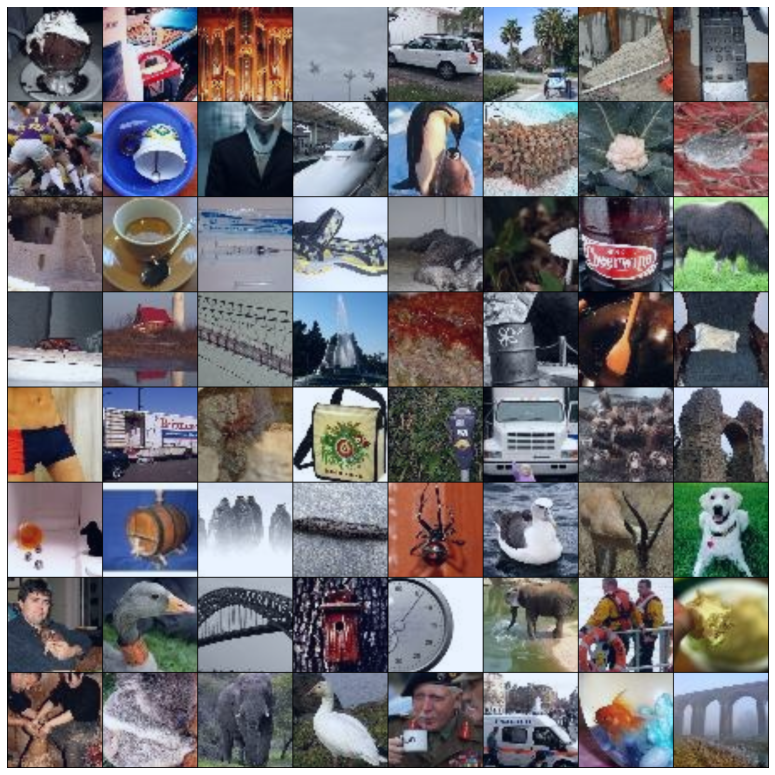

In [3]:
dataloader = load_dataset(data_directory, batch_size=128, subset_size=2, if_subset=True)

# use od dataloader:
#  for epoch in range(number_of_epochs):
            # for i, data in enumerate(dataloader, 0):

real_batch = next(iter(dataloader))

plt.figure(figsize=(14,14))
plt.axis("off")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [4]:
import torchvision.models as models

In [5]:
resnet18 = models.resnet18(pretrained=True)

In [6]:
#predict from dataloader

def predict_from_dataloader(dataloader, model, device):
    model.eval()
    model.to(device)
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            if i == 0:
                all_predicted = predicted
                all_labels = labels
            else:
                all_predicted = torch.cat((all_predicted, predicted), 0)
                all_labels = torch.cat((all_labels, labels), 0)
    return all_predicted, all_labels

In [7]:
all_predicted, all_labels = predict_from_dataloader(dataloader, resnet18, device)
from sklearn.metrics import accuracy_score  
accuracy_score(all_labels.cpu().numpy(), all_predicted.cpu().numpy())

0.0

In [8]:
#all labels into class names
training_folder_name = './calibration_datasets/tiny_imagenet/train'
classes = sorted(os.listdir(training_folder_name))
all_label_classes=[classes[i] for i in all_labels.cpu().numpy()]
all_label_classes

['n04146614',
 'n04067472',
 'n04067472',
 'n06596364',
 'n03179701',
 'n04597913',
 'n04507155',
 'n07871810',
 'n07920052',
 'n04149813',
 'n04285008',
 'n02977058',
 'n02814860',
 'n01910747',
 'n03670208',
 'n02963159',
 'n07753592',
 'n02793495',
 'n04376876',
 'n04275548',
 'n03649909',
 'n02481823',
 'n03649909',
 'n03854065',
 'n03970156',
 'n03662601',
 'n03447447',
 'n03444034',
 'n03891332',
 'n04398044',
 'n04254777',
 'n09256479',
 'n07873807',
 'n07768694',
 'n07614500',
 'n03763968',
 'n02106662',
 'n04532106',
 'n03584254',
 'n03255030',
 'n04311004',
 'n03250847',
 'n03970156',
 'n09332890',
 'n02999410',
 'n04487081',
 'n02279972',
 'n09193705',
 'n02909870',
 'n03544143',
 'n02132136',
 'n04366367',
 'n03617480',
 'n01774384',
 'n04074963',
 'n03404251',
 'n03388043',
 'n01641577',
 'n09428293',
 'n03733131',
 'n04532670',
 'n07614500',
 'n04008634',
 'n03393912',
 'n02058221',
 'n07875152',
 'n02917067',
 'n03085013',
 'n03089624',
 'n01774750',
 'n01629819',
 'n025

In [9]:
mapping_path='./LOC_synset_mapping.txt'

class_mapping_dict = {}
class_mapping_dict_number = {}
mapping_class_to_number = {}
mapping_number_to_class = {}
i = 0
for line in open(mapping_path):
    class_mapping_dict[line[:9].strip()] = line[9:].strip()
    class_mapping_dict_number[i] = line[9:].strip()
    mapping_class_to_number[line[:9].strip()] = i
    mapping_number_to_class[i] = line[:9].strip()
    i+=1


In [10]:
#mapping_number_to_class
all_predicted_classes=[]
for i in range(len(all_predicted)):
    predicted_np=all_predicted.cpu().numpy()
    new=mapping_number_to_class[predicted_np[i]]
    all_predicted_classes.append(new)
all_predicted_classes

['n04146614',
 'n04086273',
 'n03000684',
 'n06596364',
 'n04344873',
 'n07590611',
 'n02099429',
 'n01496331',
 'n07932039',
 'n04149813',
 'n03000684',
 'n01756291',
 'n04344873',
 'n02074367',
 'n04542943',
 'n04591157',
 'n07584110',
 'n04604644',
 'n04152593',
 'n01873310',
 'n03347037',
 'n02483708',
 'n03649909',
 'n04429376',
 'n03447721',
 'n04336792',
 'n02966193',
 'n02835271',
 'n04458633',
 'n03000684',
 'n02951585',
 'n03786901',
 'n07590611',
 'n07768694',
 'n04579145',
 'n04591157',
 'n02091467',
 'n04429376',
 'n02786058',
 'n03255030',
 'n04311004',
 'n03250847',
 'n03595614',
 'n02071294',
 'n03998194',
 'n03796401',
 'n02279972',
 'n01630670',
 'n03929660',
 'n03954731',
 'n02132136',
 'n03838899',
 'n03866082',
 'n01773549',
 'n02087046',
 'n02106382',
 'n02132136',
 'n01873310',
 'n03764736',
 'n03733131',
 'n04311004',
 'n01496331',
 'n03095699',
 'n04005630',
 'n02058221',
 'n07716906',
 'n02917067',
 'n04264628',
 'n04443257',
 'n01688243',
 'n13044778',
 'n023

In [11]:
suma=0
wszystkie=0
for i in range(len(all_predicted_classes)):
    wszystkie+=1
    if all_predicted_classes[i]==all_label_classes[i]:
        suma+=1

In [12]:
suma/wszystkie

0.2275